In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy.linalg import norm

In [2]:
np.random.seed(7)

# Perceptrons and Back propagation

# Submit to moodle by the 25th November - Please submit a PDF version of your notebook

## One layer perceptron -  Linear separation

We start by generating _blobs_. In this setting data is linearly separable, we can thus use a single layer perceptron.

$$ \hat{y} = W^\top x + b $$
$$ \hat{P}(y_j = 1) = Softmax(\hat{y})_j $$

With $W \in M_{N,C}(\mathbb{R})$ and $b$ a vector of size $C$. $N,C$ the dimension of the input and the number of classes.

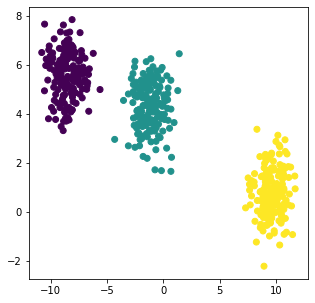

In [3]:
X, Y = make_blobs(n_samples=500, n_features=2)
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()
Y = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)

### Task 1: Implement softmax and the forward pass of a single layer percepton.

In [5]:
def softmax(x):
    """
    Takes the output of a layer as input and returns a probability distribution 
    input:
        x (np.array)
    
    returns:
        x (np.array)
    """
    exp = np.exp(x)
    return exp/np.sum(exp)

def forward_one_layer(W, b, x):
    """
    Computes the forward pass of a single layer perceptron
    input:
        W (np.array): (INPUT_SHAPE, N_CLASSES) The weight matrix of the perceptron
        b (np.array): (N_CLASSES, 1) The bias matrix of the perceptron
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron

    returns:
        (np.array) (C, 1)
    """
    return softmax(W.T @ x + b)

The loss typically associated with a classification problem is the cross entropy loss:
$$ loss = -\log(\hat{P}(y_j = 1)) $$
### Question 1 (2 points): Derive the gradients of loss with respect to $W$ and $b$.

$$\nabla_W loss = ?$$
$$\nabla_b loss = ?$$

<br>
<br>

To calculate the gradient we start by applying the chain rule on the simplified form of the loss function, which depends only on y: 

$$
\begin{array}{rcl}
\dfrac{\partial loss}{\partial W_{i,k}} & = & \dfrac{\partial loss}{\partial y_k}\dfrac{\partial y_k}{\partial W_{i,k}} = \dfrac{\partial loss}{\partial y_k} x_i \\ 
\dfrac{\partial loss}{\partial b_{k}} & = & \dfrac{\partial loss}{\partial y_k}\dfrac{\partial y_k}{\partial b_{k}} = \dfrac{\partial loss}{\partial y_k} 
\end{array}
$$

<br>
<br>

Simplifying the loss function:
$$
\begin{array}{rcl}
 loss & = & -\log\left( \hat{P}(y_j = 1) \right)\\
 & = & - \log \left( \dfrac{e^{y_j}}{\sum_{k=1}^{C} e^{y_k} } \right) \\
 & = & \log \left( \sum_{k=1}^{C} e^{y_k} \right) - y_j \\
\end{array}
$$ 
<br>
<br>
and $y_k = W^T_{(k,\cdot)}x + b_k = \sum_{i=1}^{C} w_{i,k}x_i + b_k$.

<br>
<br>

Then:
- For $k \neq j$:
$$
\begin{array}{rcl}
\dfrac{\partial loss}{\partial W_{i,k}} & = & \dfrac{e^{y_k}}{\sum_{m=1}^{C} e^{y_m}} x_i  \\
 & = & Softmax(\hat{y})_k x_i
\end{array}
$$

$$
\begin{array}{rcl}
\dfrac{\partial loss}{\partial b_k} & = & \dfrac{e^{y_k}}{\sum_{m=1}^{C} e^{y_m} } \\
 & = & Softmax(\hat{y})_k
\end{array}
$$


- For $k = j$:
$$
\begin{array}{rcl}
\dfrac{\partial loss}{\partial W_{i,j}} & = & (\dfrac{e^{y_j}}{\sum_{m=1}^{C} e^{y_m} } - 1) x_i \\
 & = & \left( Softmax(\hat{y})_j - 1\right)  x_i  
\end{array}
$$

$$
\begin{array}{rcl}
\dfrac{\partial loss}{\partial b_j} & = & \dfrac{e^{y_j}}{\sum_{m=1}^{C} e^{y_m} } - 1 \\
 & = & Softmax(\hat{y})_j - 1
\end{array}
$$

Our final result for the gradient is:
$$
\begin{array}{rcl}
\nabla_W loss & = & x\left( Softmax(\hat{y}) - y\right)^T
\end{array}
$$

$$
\begin{array}{rcl}
\nabla_b loss & = & Softmax(\hat{y}) - y
\end{array}
$$


### Task 2: Implement the gradients

In [6]:
def compute_grads_one_layer(softmaxed, x, y):
    """
    inputs:
        softmaxed (np.array): (N_CLASSES, 1)
        y (np.array): (N_CLASSES, 1)
        x (np.array): (INPUT_SHAPE, 1)
        
    returns:
        d_W (np.array): (INPUT_SHAPE, N_CLASSES) Gradient of the loss with respect to the weight matrix
        d_b (np.array): (N_CLASSES, 1) Gradient of the loss with respect to the bias matrix 
    """
    d_b = softmaxed - y
    d_W = x.reshape(-1,1) @ d_b.reshape(1,-1) 
    
    return  d_W, d_b

def compute_loss(softmaxed, y):
    """
    inputs:
        softmaxed (np.array): (N_CLASSES, 1)
        y (np.array): (N_CLASSES, 1)
        
    returns:
        (float)
    """
    return float(-np.log( max(softmaxed.T @ y, 1e-10) ))

### Question 2 (1 points): As a sanity check, we want to compare the gradients we calculated to approximated gradients. How could we do this ?

#### Answer
One can estimate the gradient of W using an approximation of the formal definition of the derivative. 

$$ (\nabla_W loss)_{i,j} = \lim_{ h\to0} \frac{loss(W_{i,j} +  h) - loss(W_{i,j})}{ h} $$


### Task 3: Implement the approx gradient function for the weight matrix

In [7]:
def approx_grad_W(W, b, x, y, h=0.0001):
    """
    Approximates the gradient with respect to W
    input:
        W (np.array): (INPUT_SHAPE, N_CLASSES) The weight matrix of the perceptron
        b (np.array): (N_CLASSES, 1) The bias matrix of the perceptron
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron
        x (np.array): (N_CLASSES, 1) The input of the perceptron
        h (float): variation

    returns:
        d_W_approx (np.array): (INPUT_SHAPE, N_CLASSES) 
    """
    n_features, n_classes = W.shape
    d_W_approx = np.zeros((n_features, n_classes))
    previous_softmaxed = forward_one_layer(W,b,x)
    
    for i in range (n_features):
        for j in range (n_classes):
            
            
            W[i][j]+=h
            new_softmaxed = forward_one_layer(W,b,x)
            
            d_W_approx[i][j] = ( compute_loss(new_softmaxed, y) - compute_loss(previous_softmaxed, y) )/h
            W[i][j]-=h
            
    
    
    return d_W_approx

The following function trains the perceptron

In [8]:
def train_one_layer(X_train, Y_train, X_test, Y_test, lr,
                    n_it=1000, test_freq=10, random_seed=42):
    
    INPUT_SHAPE = X_train.shape[1]
    N_CLASSES = Y_train.shape[1]
    
    # Initialise metrics lists
    loss = []
    acc = []
    test_acc = []
    approx_grads = []
    grads = []
    
    # Initialisation of the weigths
    np.random.seed(random_seed)
    b = rand.normal(size=(N_CLASSES, 1))
    W = rand.normal(size=(INPUT_SHAPE, N_CLASSES))
    
    # Shuffling data
    indexes = rand.randint(X_train.shape[0], size=n_it)
    # training loop
    for it, i in enumerate(indexes):
        x = X_train[i,:].reshape(-1,1)
        y = Y_train[i,:].reshape(-1,1)

        # Forward passs
        softmaxed = forward_one_layer(W, b, x)
        # Back probagaiton
        d_W, d_b = compute_grads_one_layer(softmaxed, x, y)
        W -= lr * d_W
        b -= lr * d_b
        
        # Recording approximate gradients
        grads.append(d_W)
        approx_grads.append(approx_grad_W(W, b, x, y))
        
        # Metrics recording
        loss.append(compute_loss(softmaxed, y))
        acc.append(np.argmax(softmaxed) == np.argmax(y))
        
        # Test loop
        if it % test_freq == 0:
            acc_temp = []
            for i in range(X_test.shape[0]):
                x = X_train[i,:].reshape(-1,1)
                y = Y_train[i,:].reshape(-1,1)
                softmaxed = forward_one_layer(W, b, x)
                acc_temp.append(np.argmax(softmaxed) == np.argmax(y))
                
            test_acc.append(np.mean(acc_temp))

    return W, b, loss, acc, test_acc, np.stack(grads, -1), np.stack(approx_grads, -1)

### Task 4 (4 points): Using the previous function train the model. By producing an appropriate set of plots validate that it trained correctly and that you computed the correct gradients. Remember that a plot should be self explanatory.

In [9]:
W, b, loss, acc, test_acc, grads, approx_grads = train_one_layer(X_train, Y_train, X_test, Y_test, 0.01)

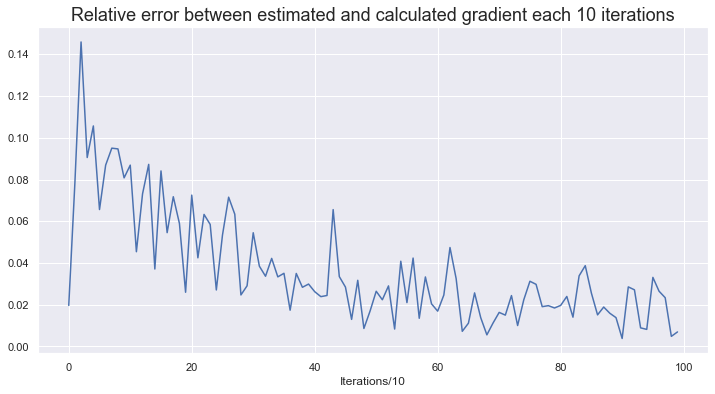

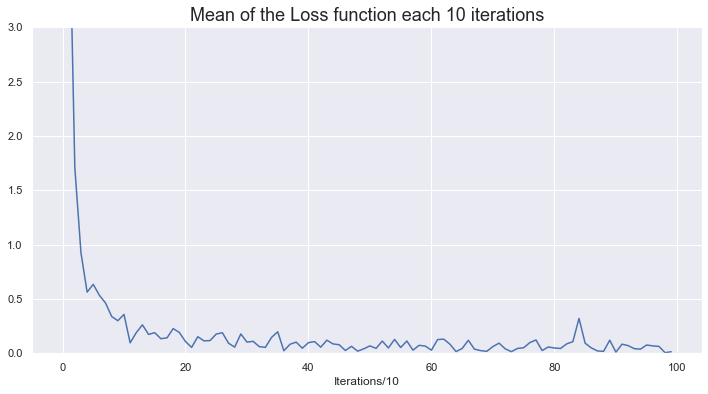

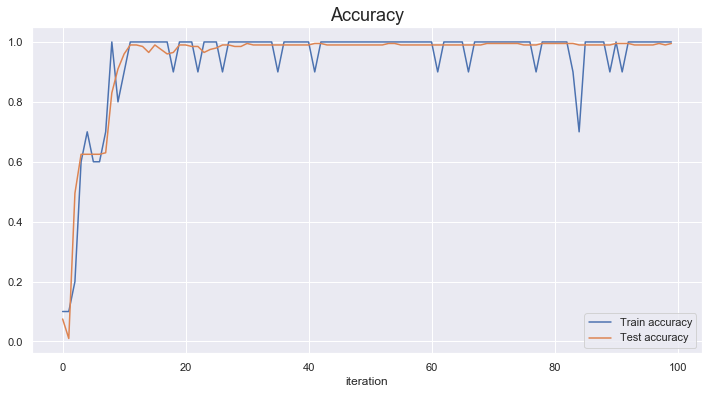

In [10]:
sns.set()
n_iterations = len(acc)


#Function that returns the mean of 10 itens within a list 
get_mean_list = lambda myList, i: ( np.sum([myList[i:i+10]]) / 10)


#GRADS DIFF RELATIVE ERROR
get_relative_error = lambda i: (norm(grads[:,:,i] - approx_grads[:,:,i]) / (norm(grads[:,:,i]) + norm(approx_grads[:,:,i])))

gradsRelativeError = [get_relative_error(i) for i in range(n_iterations)]
gradsRelativeError = [get_mean_list(gradsRelativeError,i) for i in range(0, n_iterations, 10)]


plt.figure(figsize = (12,6))
plt.plot(gradsRelativeError)
plt.title("Relative error between estimated and calculated gradient each 10 iterations", fontsize=18)
plt.xlabel("Iterations/10")
plt.show()


#LOSS 
Loss = [get_mean_list(loss,i) for i in range(0, n_iterations, 10)]

plt.figure(figsize = (12,6))
plt.plot(Loss)
plt.ylim(0,3)
plt.title("Mean of the Loss function each 10 iterations", fontsize=18)
plt.xlabel("Iterations/10")
plt.show()


#ACCURACY
# Training data accuracy
Acc = [get_mean_list(acc,i) for i in range(0, n_iterations, 10)]

plt.figure(figsize = (12,6))
plt.plot(Acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.title("Accuracy", fontsize=18)
plt.xlabel("iteration")
plt.legend()
plt.show()



In [ ]:
sns.reset_orig()

# Non linearity

Now that the perceptron is train we can visualize its decusion funciton. 

In [12]:
def plot_decision(X, Y, forward, figure=None):
    """Plots the decision function of a perceptron with respect to a forward funciton
    
    input:
        X, Y (np.array): Test data
        forward (function): only accepts x as input (Ex: lambda x: forward_one_layer(W, b, x))
        figure (plt.figure): optional, usefull if you dont want to generate any new figure, 
                    in the case of suplots.
    """
    markers=[".", "*", "D"]
    low0, high0 = np.min(X[:,0]), np.max(X[:,0])
    low1, high1 = np.min(X[:,1]), np.max(X[:,1])
    data = np.zeros((100,100,Y.shape[1]))
    for i1, x1 in enumerate(np.linspace(low0,high0,100)):
        for i2, x2 in enumerate(np.linspace(low1,high1,100)):
            x = np.array([x1, x2]).reshape(-1, 1)
            softmaxed = forward(x)
            data[i2, i1, :] = softmaxed.reshape(-1)
    if Y.shape[1] < 3:
        data = data[:,:,0]
    
    if figure is None:
        plt.figure(figsize=(10,10))
        
    plt.imshow(data, extent=(low0,high0,low1,high1), origin='lower', interpolation='gaussian')
    for c in range(Y.shape[1]):
        plt.scatter(X[np.argmax(Y, 1) == c, 0], X[np.argmax(Y, 1) == c, 1], c='k', 
                    marker=markers[c], label="class %i" % c)
        
    plt.legend()

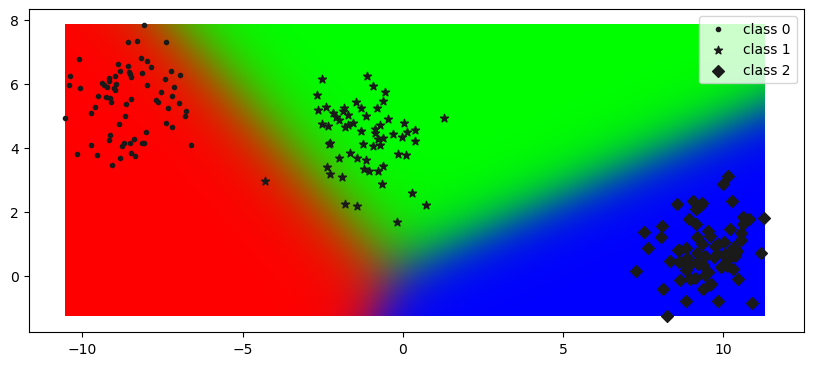

In [13]:
plot_decision(X_test, Y_test, lambda x: forward_one_layer(W, b, x))

The data we used was linearly separable, but what if it is not ? 

### Task 5 (1 point): Using the following data train a new perceptron and visualize its decision function. 

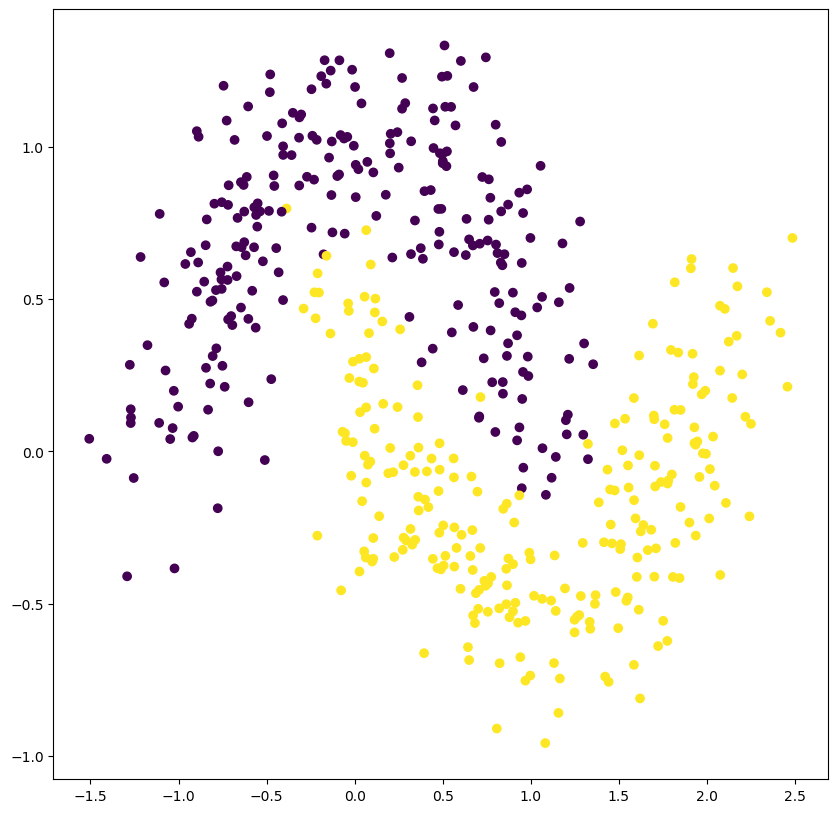

In [14]:
X, Y = make_moons(n_samples=500, noise=.2)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()
Y = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)

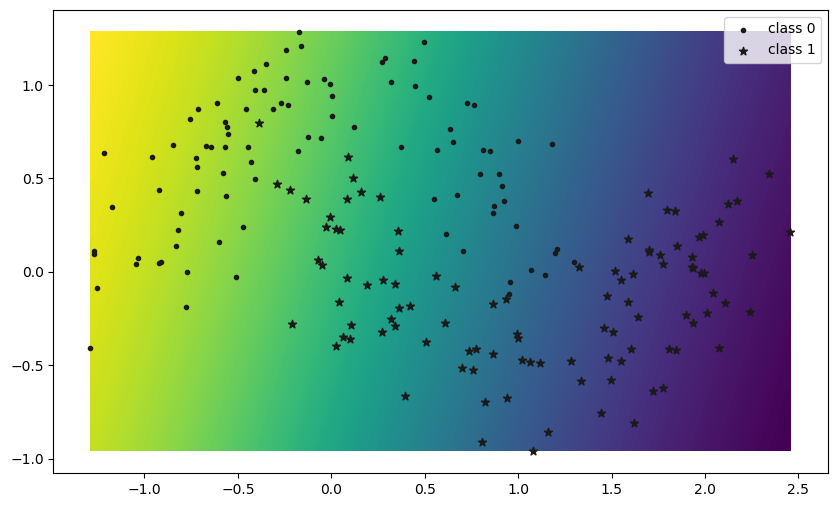

In [15]:
W, b, loss, acc, test_acc, grads, approx_grads = train_one_layer(X_train, Y_train, X_test, Y_test, 0.001)
plot_decision(X_test, Y_test, lambda x: forward_one_layer(W, b, x))

# Two Layer perceptron - Feed forward neural network

In neural networks, non linearity comes from having at least one hidden layer and a non linear activation function such as the $ReLU$ function.
$$ h = ReLU(W^{h\top} x + b^h) $$
$$ \hat{y} = W^{o\top} h + b^o $$
$$ \hat{P}(y_j = 1) = Softmax(\hat{y})_j $$

With $W^h \in M_{N,H}(\mathbb{R})$ and $W^o \in M_{C,H}(\mathbb{R})$ and $b^h$, $b^o$ vectors of corresponding dimensions. $H$ is the number of hidden units.

The $ReLU$ funciton is defined as:

$$ ReLU(x) = 
\begin{cases}
0 \textrm{ if } x < 0\\
x \textrm{ otherwise }
\end{cases}
$$

### Question 3 (2 points): Derive the gradients with respect to $W_h$ and $b_h$.


The gradient for the weights and the bias of the output layer is the same as before, however with the input of the hidden activations **h**:

$$
\begin{array}{rcl}
\nabla_{W_o} loss =  h\left( Softmax(\hat{y}) - y\right)^T \\
\nabla_{h_o} loss =  \left( Softmax(\hat{y}) - y\right)^T
\end{array}
$$


In the following step we have to consider the gradient of the loss function with respect to the hidden layers and the derivative of the ReLU function:

$$
\begin{array}{rcl}
\nabla_{h} loss =  W_o\left( Softmax(\hat{y}) - y\right)\\
\dfrac{d}{dx}ReLU(x) =  \left\{ \begin{array}{ll}
      0 & x < 0 \\
      1 & x\geq 0 \\
\end{array} \right. 
\end{array}
$$

Computing therefore the gradient of the loss with respect of the hidden layer before activation, wich we call out:

$$
\nabla_{out} loss = ( W_o\left( Softmax(\hat{y}) - y\right))*\dfrac{dReLU(h)}{dh}\\
$$

Where * denotes element-wise product.
With the same process of the chain rule, we have the last two gradients:

$$
\begin{array}{rcl}
\nabla_{W_h} loss & = & x(\nabla_{out} loss)^T \\
\nabla_{h_h} loss & = &  \nabla_{out} loss
\end{array}
$$




### Task 5 (5 points): Based on the previous implementation complete the following functions and train a 2 layers perceptron.

In [16]:
def relu(x):
    """
    input:
        x (np.array)
    
    returns:
        x (np.array)
    """
    return (x>0)*x


def d_relu(x):
    """Computes the derivative of the relu
    input:
        x (np.array)
    
    returns:
        x (np.array)
    """
    return (x>0)*1

def forward_two_layers(Wo, bo, Wh, bh, x):
    """Forward pass of a teo layer perceptron with relu activation
    input:
        Wh (np.array): (INPUT_SHAPE, HIDDEN_SHAPE) The weight matrix of the hidden layer
        Wo (np.array): (HIDDEN_SHAPE, N_CLASSES) The weight matrix of the output layer
        bh (np.array): (HIDDEN_SHAPE, 1) The bias matrix of the hidden layer
        bo (np.array): (N_CLASSES, 1) The bias matrix of the output layer
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron

    returns:
        softmaxed (np.array): (N_CLASSES, 1) the output of the network after final activation
        hidden (np.array): (HIDDENT_SHAPE, 1) the output of the hidden layer after activation
        out (np.array): (N_CLASSES, 1) the output of the network before final activation
    """
    hidden = relu( Wh.T @ x + bh )
    out = Wo.T @ hidden + bo
    softmaxed = softmax(out)
    
    
    return softmaxed, hidden, out
    
def compute_grads_two_layers(hidden, softmaxed, Wo, x, y):
    """Forward pass of a teo layer perceptron with relu activation
    input:
        hidden (np.array): (HIDDENT_SHAPE, 1) the output of the hidden layer after activation
        softmaxed (np.array): (N_CLASSES, 1) the output of the network after final activation
        Wo (np.array): (HIDDEN_SHAPE, N_CLASSES) The weight matrix of the output layer
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron
        y (np.array): (N_CLASSES, 1) Ground truth class
    
    returns:
        d_Wo (np.array): (HIDDEN_SHAPE, N_CLASSES) Gradient with respect 
                        to the weight matrix of the output layer
        d_bo (np.array): (N_CLASSES, 1) Gradient with respect to the bias matrix of the output layer
        d_Wh (np.array): (INPUT_SHAPE, HIDDEN_SHAPE) Gradient with respect to the 
                        weight matrix of the hidden layer
        d_bh (np.array): (HIDDEN_SHAPE, 1) Gradient with respect to the bias matrix of the hidden layer
    """
    d_Wo, d_bo = compute_grads_one_layer(softmaxed, hidden, y)
    
    d_bh = (Wo @ (softmaxed-y)) * d_relu(hidden)
    d_Wh = x @ d_bh.reshape(1,-1)
    
    return d_Wo, d_bo, d_Wh, d_bh



In [17]:
def train_two_layer(X_train, Y_train, X_test, Y_test, lr, n_hidden,
                    n_it=1000, test_freq=10, random_seed=42):
    
    
    INPUT_SHAPE = X_train.shape[1]
    N_CLASSES = Y_train.shape[1]
    
    
    # Initialise metrics lists
    loss = []
    acc = []
    test_acc = []

    
    # Initialisation of the weigths
    np.random.seed(random_seed)
    bh = rand.normal(size=(n_hidden, 1))
    Wh = rand.normal(size=(INPUT_SHAPE, n_hidden))
    bo = rand.normal(size=(N_CLASSES, 1))
    Wo = rand.normal(size=(n_hidden, N_CLASSES))
    
    # Shuffling data
    indexes = rand.randint(X_train.shape[0], size=n_it)
    
    # training loop
    for it, i in enumerate(indexes): # 'i' represents iteration and 'it' represents x vector 
        x = X_train[i,:].reshape(-1,1)
        y = Y_train[i,:].reshape(-1,1)

        # Forward passs
        softmaxed, hidden, out = forward_two_layers(Wo, bo, Wh, bh, x)
        
        # Back probagaiton
        d_Wo, d_bo, d_Wh, d_bh = compute_grads_two_layers(hidden, softmaxed, Wo, x, y)
        
        Wo -= lr * d_Wo
        bo -= lr * d_bo
        Wh -= lr * d_Wh
        bh -= lr * d_bh
        
        
        # Metrics recording
        loss.append(compute_loss(softmaxed, y))
        acc.append(np.argmax(softmaxed) == np.argmax(y))
        
        # Test loop
        if it % test_freq == 0:
            acc_temp = []
            for i in range(X_test.shape[0]):
                x = X_train[i,:].reshape(-1,1)
                y = Y_train[i,:].reshape(-1,1)
                softmaxed, _, _ = forward_two_layers(Wo, bo, Wh, bh, x)
                acc_temp.append(np.argmax(softmaxed) == np.argmax(y))
                
            test_acc.append(np.mean(acc_temp))
        
        
        

    return Wo, bo, Wh, bh, loss, acc, test_acc

In [18]:
Wo, bo, Wh, bh, loss, acc, test_acc = train_two_layer(X_train, Y_train, X_test, Y_test, 0.1, 16)

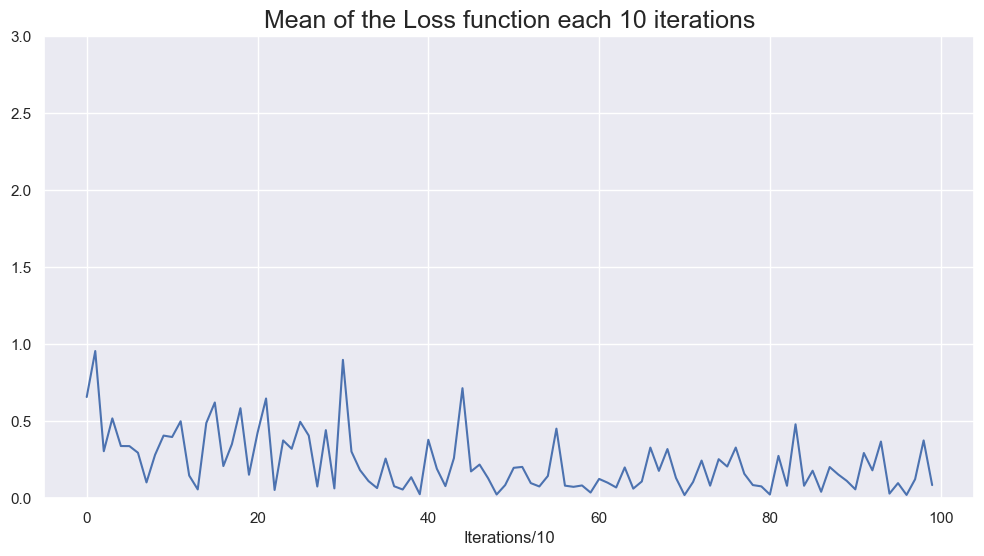

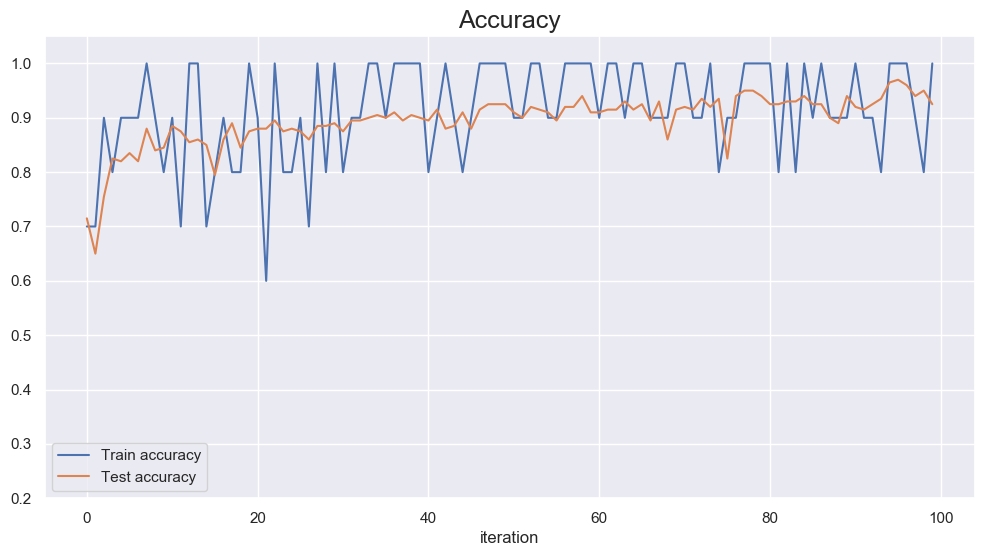

In [19]:
sns.set()
n_iterations = len(acc)


#Function that returns the mean of 10 itens within a list 
get_mean_list = lambda myList, i: ( np.sum([myList[i:i+10]]) / 10)


#LOSS 
Loss = [get_mean_list(loss,i) for i in range(0, n_iterations, 10)]

plt.figure(figsize = (12,6))
plt.plot(Loss)
plt.ylim(0,3)
plt.title("Mean of the Loss function each 10 iterations", fontsize=18)
plt.xlabel("Iterations/10")
plt.show()


#ACCURACY
# Training data accuracy
Acc = [get_mean_list(acc,i) for i in range(0, n_iterations, 10)]

plt.figure(figsize = (12,6))
plt.plot(Acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.title("Accuracy", fontsize=18)
plt.ylim(0.2,1.05)
plt.xlabel("iteration")
plt.legend()
plt.show()

In [ ]:
sns.reset_orig()

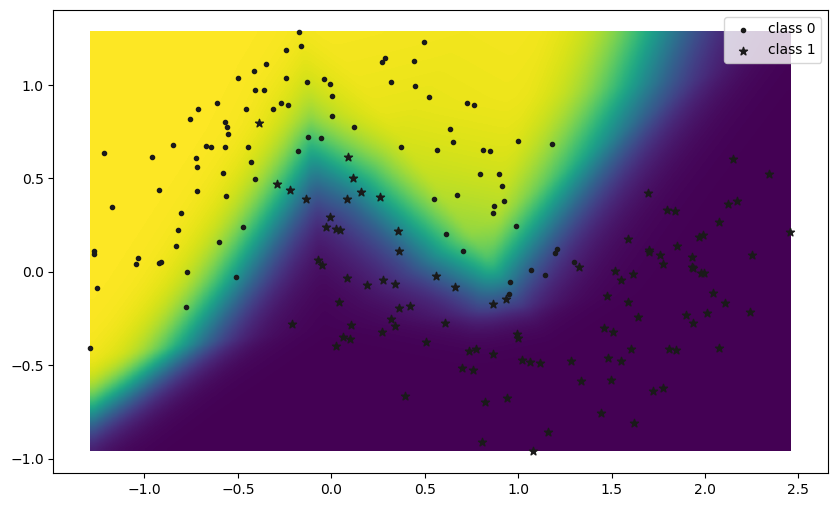

In [21]:
plot_decision(X_test, Y_test, lambda x: forward_two_layers(Wo, bo, Wh, bh, x)[0])

### Task 7 (3 points): The non linearity of the decision function is conditionned by the number of units, visualize this effect. What can you comment on the smoothness of the boundary ? (Be carefull, to visualize this you need to properly train the networks)

To better visualize this let's generate new data.

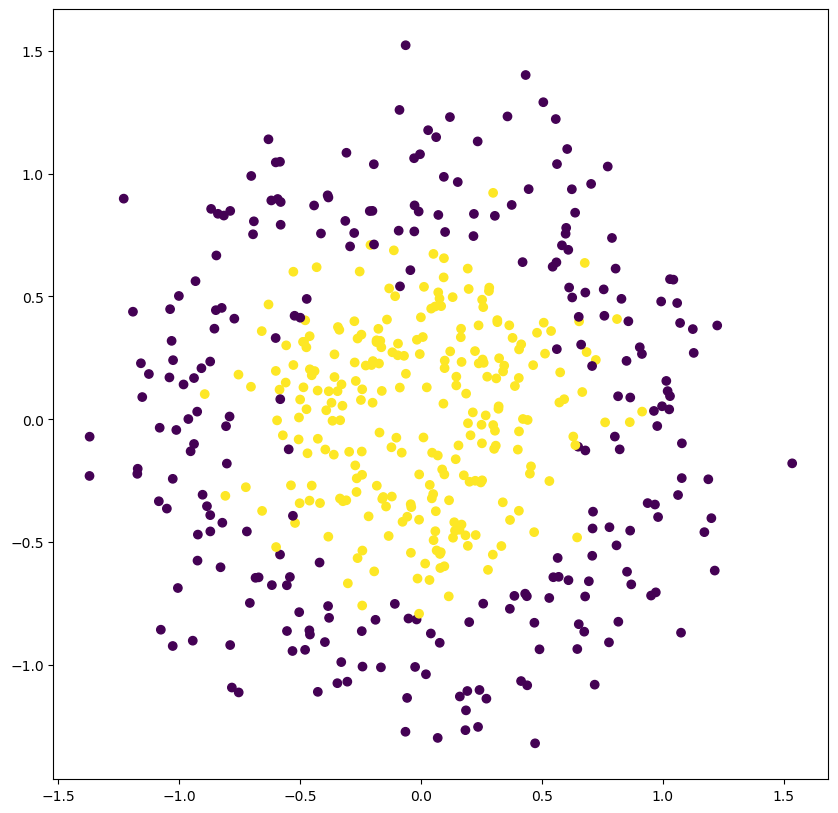

In [22]:
X, Y = make_circles(n_samples=500, noise=.2, factor=0.4)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()
Y = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)

In [23]:
Wo, bo, Wh, bh, loss, acc, test_acc = train_two_layer(X_train, Y_train, X_test, Y_test, 0.1, 16)

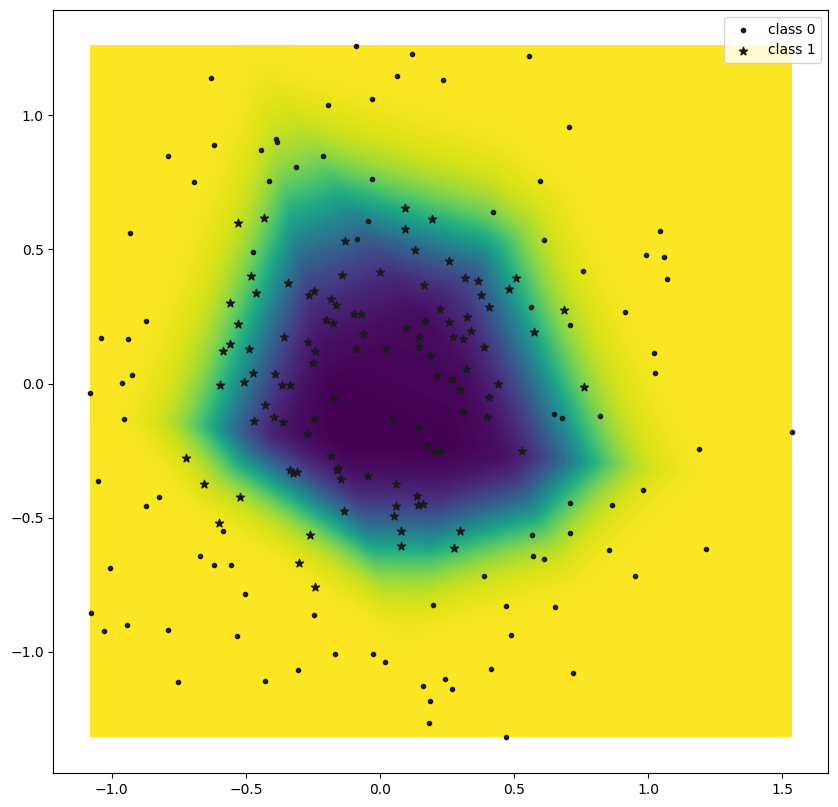

In [24]:
plot_decision(X_test, Y_test, lambda x: forward_two_layers(Wo, bo, Wh, bh, x)[0])

### Task 8 (2 points): To have a smooth boundary we need to change the activation. Change the activation from relu to tanh, and vizualize the result.

In [25]:
def forward_two_layers(Wo, bo, Wh, bh, x):
    """Change this funciton to uses tanh
    """
    hidden = np.tanh(Wh.T @ x + bh)
    out = Wo.T @ hidden + bo
    softmaxed = softmax(out)
    
    return softmaxed, hidden, out
    
def compute_grads_two_layers(hidden, softmaxed, Wo, x, y):
    """Change this funciton to uses tanh
    """
    d_bo = softmaxed - y
    d_Wo = hidden @ d_bo.T
    
    d_bh = (Wo @ d_bo) * (1 - (hidden ** 2))
    d_Wh = x @ d_bh.T
    
    return d_Wo, d_bo, d_Wh, d_bh

In [26]:
Wo, bo, Wh, bh, loss, acc, test_acc = train_two_layer(X_train, Y_train, X_test, Y_test, 0.1, 16)

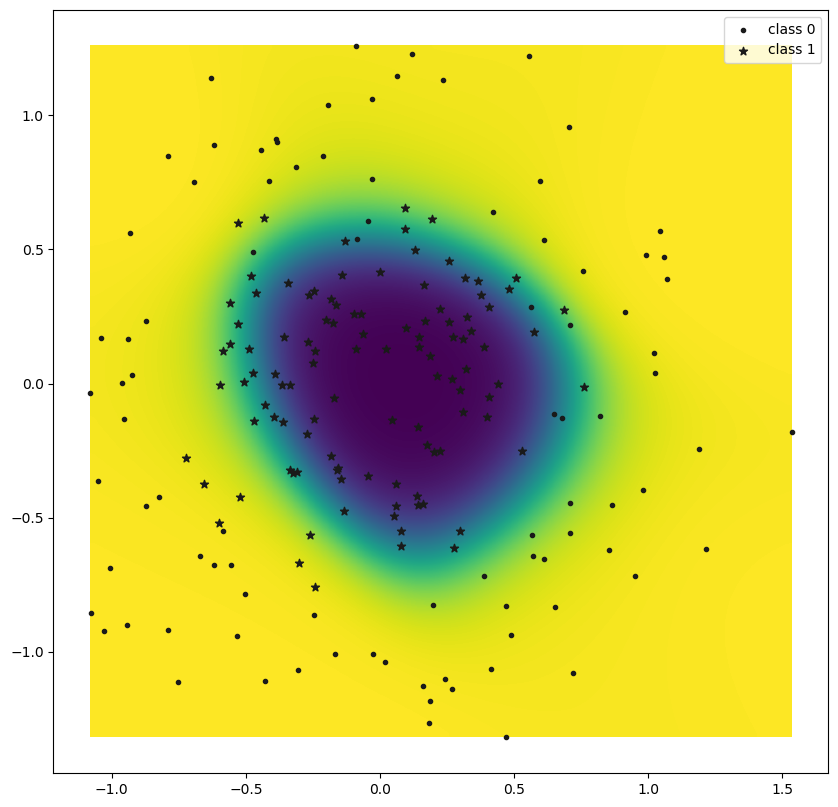

In [27]:
plot_decision(X_test, Y_test, lambda x: forward_two_layers(Wo, bo, Wh, bh, x)[0])